In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('bmh')

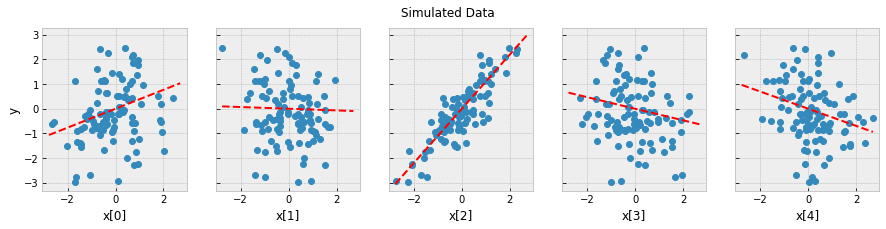

In [2]:
np.random.seed(0)

ndims = 5
ndata = 100
X = np.random.randn(ndata, ndims)
w_ = np.random.randn(ndims)

noise_ = 0.1 * np.random.randn(ndata)
y_obs = X.dot(w_) + noise_


fig, axes = plt.subplots(sharey=True, ncols=ndims, figsize=(15, 3))

t = np.linspace(X.min(), X.max())
for idx, (ax, x) in enumerate(zip(axes.ravel(), X.T)):
    ax.plot(x, y_obs, 'o');
    ax.plot(t, w_[idx] * t, 'r--')
    ax.set_xlabel(f'x[{idx}]')
axes[0].set_ylabel('y')
fig.suptitle('Simulated Data');

## The Model

We have generated a linear regression dataset with 5 dimensions and 100 datapoints. 

In each library, we will define the joint probability distribution

$$
p(\mathbf{w}) \sim \mathcal{N}(\mathbf{0}, I_5)\\
p(\mathbf{y} | X, \mathbf{w}) \sim \mathcal{N}(X\mathbf{w}, 0.1I_{100}),
$$
where $I_5$ is a $5 \times 5$ identity matrix, and $I_{100}$ a $100 \times 100$ identity.

We then provide code to sample 1,000 draws from the posterior distribution: 

$$
p(\mathbf{w} | X, \mathbf{y}) \propto p(\mathbf{y} | X, \mathbf{w}) p(\mathbf{w})
$$

Note that in this case we can just do the math, and the actual posterior is

$$
p(\mathbf{w} | X, \mathbf{y}) = \mathcal{N}((X^TX + I_5)^{-1}X^Ty, (X^TX + I_5)^{-1})
$$



# Hamiltonian Mxnet

In [3]:
import sys
sys.path.append("../") 

In [4]:
import mxnet as mx
from mxnet import nd, autograd, gluon

model_ctx=mx.cpu()
hyper={'alpha':10.,'scale':0.1}

In [5]:
import importlib

try:
    importlib.reload(hamiltonian.models.linear)
    importlib.reload(hamiltonian.inference.hmc)
    importlib.reload(hamiltonian.inference.find_reasonable_epsilon)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

no modules loaded yet


In [6]:
from hamiltonian.inference.hmc import hmc
from hamiltonian.models.linear import linear

model=linear(hyper,ctx=model_ctx)

In [7]:
X_train=nd.array(X,ctx=model_ctx)
y_train=nd.array(y_obs,ctx=model_ctx)

In [8]:
par={'weights':nd.random_normal(shape=ndims,ctx=model_ctx),'bias':nd.random_normal(shape=1,ctx=model_ctx)}
inference=hmc(model,par,step_size=0.1,ctx=model_ctx)

In [ ]:
posterior_samples_1,loss_1=inference.fit(epochs=4000,burn_in=1000,
                           path_length=100,X_train=X_train,y_train=y_train)

 63%|██████▎   | 3144/5000 [27:37<15:02,  2.06it/s] 

In [10]:
posterior_samples_numpy_1=dict()

for var in posterior_samples_1.keys():
    posterior_samples_numpy_1.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples_1[var]]),0)
        })

In [11]:
import arviz as az

dataset1=az.convert_to_inference_data(posterior_samples_numpy_1)

In [12]:
par={'weights':nd.random_normal(shape=ndims,ctx=model_ctx),'bias':nd.random_normal(shape=1,ctx=model_ctx)}
inference=hmc(model,par,step_size=0.1,ctx=model_ctx)
posterior_samples_2,loss_2=inference.fit(epochs=4000,burn_in=1000,
                           path_length=100,X_train=X_train,y_train=y_train)

100%|██████████| 5000/5000 [11:55<00:00,  6.99it/s]


In [13]:
posterior_samples_numpy_2=dict()

for var in posterior_samples_2.keys():
    posterior_samples_numpy_2.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples_2[var]]),0)
        })

In [14]:
dataset2=az.convert_to_inference_data(posterior_samples_numpy_2)

In [18]:
dataset = az.concat(dataset1, dataset2, dim="chain")

In [19]:
az.summary(dataset)

arviz - WARNING - Array contains NaN-value.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
weights[0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weights[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weights[2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weights[3],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weights[4],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bias[0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## PyMC3

In [181]:
import pymc3 as pm
import theano.tensor as tt

ModuleNotFoundError: No module named 'pymc3'

In [112]:
with pm.Model():
    w = pm.Normal('w', 0, 1, shape=ndims)
    y = pm.Normal('y', tt.dot(X, w), 0.1, observed=y_obs)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [113]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.372,0.010,0.353,0.391,0.0,0.0,6326.0,2805.0,1.0
w[1],-0.035,0.011,-0.056,-0.016,0.0,0.0,7084.0,2877.0,1.0
w[2],1.094,0.010,1.076,1.114,0.0,0.0,5531.0,3003.0,1.0
w[3],-0.234,0.010,-0.253,-0.216,0.0,0.0,6373.0,3296.0,1.0
w[4],-0.339,0.011,-0.359,-0.319,0.0,0.0,6772.0,3228.0,1.0
